In [1]:
import os
import torch
import torch_geometric as pyg
import numpy as np
import networkx as nx
from utils import load_pickle

import constants

/home/mingyang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predicting room type

This notebook can be used to train a GNN to predict room type from zoning type. Then save graph_pred files for the test set that contain the predicted room_types.

## Make dataset

In [2]:
def add_zoning_attribute(graph: nx.Graph):
    room_type = nx.get_node_attributes(graph, 'room_type')

    room_names = {node: constants.ROOM_NAMES[value] for node, value in room_type.items()}

    inv_room_mapping = {val: key for key, val in constants.ROOM_MAPPING.items()}

    room_names = {node: inv_room_mapping[value] for node, value in room_names.items()}

    zoning = {key: constants.ZONING_MAPPING[value] for key, value in room_names.items()}

    zoning_index = {key: constants.ZONING_NAMES.index(value) for key, value in zoning.items()}

    nx.set_node_attributes(graph, zoning_index, 'zoning_type')



In [3]:
from sklearn.model_selection import train_test_split

def one_hot_encode(value, num_classes):
    return torch.eye(num_classes)[value]


NUM_ROOM_TYPES = 9
NUM_ZONING_TYPES = 4

# def one_hot_encode_types(graph: nx.Graph):
#     for node in graph.nodes:
#         graph.nodes[node]['room_type'] = one_hot_encode(graph.nodes[node]['room_type'], NUM_ROOM_TYPES)
#         graph.nodes[node]['zoning_type'] = one_hot_encode(graph.nodes[node]['zoning_type'], NUM_ZONING_TYPES)

CONNECTIVITIES = ["door", "entrance", "passage"]

class GraphZoningRoomTypeDataset(torch.utils.data.Dataset):
    """
    Graph Dataset. Collects NetworkX graph from a pre-defined folder and
    transforms them to Pytorch Geometric (pyg.data.Data()) instances.
    """
    def __init__(self, path, split="train"):
        # self.graph_in_path = os.path.join(path, 'graph_in')
        self.graph_out_path = os.path.join(path, 'graph_out')

        # include graph transformations if you like
        # self.graph_transform = graph_transform

        all_files = os.listdir(self.graph_out_path)

        self.train_files, self.val_files = train_test_split(all_files, test_size=0.05, random_state=42)

        if split == "train":
            self.files = self.train_files
        elif split == "val":
            self.files = self.val_files
        else:
            raise ValueError(f"Invalid split: {split}")

    def __getitem__(self, index):

        file_name = self.files[index]

        # get access graph (name is index)
        graph_nx = load_pickle(os.path.join(self.graph_out_path, file_name))

        add_zoning_attribute(graph_nx)

        for edge in graph_nx.edges:
            graph_nx.edges[edge]['connectivity'] = CONNECTIVITIES.index(graph_nx.edges[edge]['connectivity'])

        # Remove attributes geometry, centroid
        for node in graph_nx.nodes:
            graph_nx.nodes[node].pop('geometry', None)
            graph_nx.nodes[node].pop('centroid', None)

        # graph_nx.graph[]

        # transform networkx graph to pytorch geometric graph
        graph_pyg = pyg.utils.from_networkx(graph_nx)

        # transform graph if you like
        graph_pyg = self.graph_transform(graph_pyg)

        return graph_pyg

    @staticmethod
    def graph_transform(graph_pyg):
        graph_pyg["room_type"] = one_hot_encode(graph_pyg["room_type"], NUM_ROOM_TYPES)
        graph_pyg["zoning_type"] = one_hot_encode(graph_pyg["zoning_type"], NUM_ZONING_TYPES)

        graph_pyg["connectivity"] = one_hot_encode(graph_pyg["connectivity"], len(CONNECTIVITIES))

        return graph_pyg

    def __len__(self):
        return len(self.files)


In [4]:

class GraphZoningTypeTestSet(torch.utils.data.Dataset):
    """
    Graph Dataset. Collects NetworkX graph from a pre-defined folder and
    transforms them to Pytorch Geometric (pyg.data.Data()) instances.
    """
    def __init__(self, path):
        self.graph_path = os.path.join(path, 'graph_in')

        self.files = os.listdir(self.graph_path)

    def __getitem__(self, index):

        file_name = self.files[index]

        # get access graph (name is index)
        graph_nx = load_pickle(os.path.join(self.graph_path, file_name))

        for edge in graph_nx.edges:
            graph_nx.edges[edge]['connectivity'] = CONNECTIVITIES.index(graph_nx.edges[edge]['connectivity'])

        # transform networkx graph to pytorch geometric graph
        graph_pyg = pyg.utils.from_networkx(graph_nx)

        # transform graph if you like
        graph_pyg = self.graph_transform(graph_pyg)

        graph_pyg["file_name"] = file_name

        return graph_pyg

    @staticmethod
    def graph_transform(graph_pyg):
        graph_pyg["zoning_type"] = one_hot_encode(graph_pyg["zoning_type"], NUM_ZONING_TYPES)

        graph_pyg["connectivity"] = one_hot_encode(graph_pyg["connectivity"], len(CONNECTIVITIES))

        return graph_pyg

    def __len__(self):
        return len(self.files)


In [5]:
# path = "/path/to/modified-swiss-dwellings/modified-swiss-dwellings-v1-train/"
path = "/home/mingyang/workspace/layout/dataset/modified-swiss-dwellings-v2/train"

# graph_nx = load_pickle(os.path.join(graph_path, f'{43}.pickle'))

In [6]:
# graph_nx.edges(data=True)

In [6]:
ds_train = GraphZoningRoomTypeDataset(path, split="train")

# A small portion of the training set is reserved for validation:
ds_val = GraphZoningRoomTypeDataset(path, split="val")

## Define GNN model

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

from torch import nn

class GATModel(torch.nn.Module):
    def __init__(self, num_features=NUM_ZONING_TYPES, num_edge_features=len(CONNECTIVITIES), hidden_size=32, target_size=NUM_ROOM_TYPES, num_hidden_layers=2):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_features = num_features
        self.num_edge_features = num_edge_features
        self.target_size = target_size

        self.convs = nn.ModuleList([GATConv(self.num_features if i == 0 else self.hidden_size, self.hidden_size, edge_dim=self.num_edge_features) for i in range(num_hidden_layers)])

        self.hidden_linear = nn.Linear(self.hidden_size + num_features, self.hidden_size)

        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.zoning_type, data.edge_index, data.connectivity

        for conv in self.convs:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        # x = self.convs[-1](x, edge_index, edge_attr=edge_attr) # edge features here as well
        
        x = torch.cat([x, data.zoning_type], dim=-1)

        x = self.hidden_linear(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.linear(x)

        return F.relu(x) 

## Train and eval loop:

In [8]:
from torch_geometric.loader import DataLoader

from collections import Counter

def evaluate_model(model, data_val, device="cpu"):
    model.eval()

    total_loss = 0
    accuracies = []
    ious = []

    model = model.to(device)

    with torch.no_grad():

        # Batch size should be 1, because want to evaluate each graph separately
        for data in DataLoader(data_val, batch_size=1):
            data = data.to(device)
            out = model(data)

            pred = torch.argmax(model(data.to(device)), dim=-1)

            gt = torch.argmax(data.room_type, dim=-1).to(device)
            
            # Tensor of shape (batch_size, 1)
            acc = (gt == pred).sum(dim=-1) / pred.shape[-1]

            pred_counter = Counter(pred.cpu().numpy())
            gt_counter = Counter(gt.cpu().numpy())

            iou = sum((pred_counter & gt_counter).values()) / sum((pred_counter | gt_counter).values())
            ious.append(iou)

            accuracies.append(acc.item())
            
            val_loss = F.cross_entropy(out, data.room_type)

            total_loss += val_loss.item()
    
    model.train()
    
    return total_loss, np.mean(accuracies), np.mean(ious)


def train(model, data_train, data_val, batch_size, learning_rate, n_epochs=1, device="cpu", save_loss_interval=1, print_interval=1):

    NUM_TRAIN = len(data_train)
    NUM_VAL = len(data_val)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

    # test_data = data_test[0]

    model = model.to(device)

    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        
        for data in loader:
            
            data = data.to(device)

            optimizer.zero_grad()
            
            out = model(data)
            
            loss = F.cross_entropy(out, data.room_type)
            
            epoch_loss += loss.item() 
            loss.backward()
            optimizer.step()

        if epoch % save_loss_interval == 0:
            val_loss, val_acc, val_iou = evaluate_model(model, data_val, device="cpu")

            val_loss /= NUM_VAL

            model = model.to(device)

            train_loss = epoch_loss / NUM_TRAIN
          
            if epoch % print_interval == 0:
                print(f"Epoch: {epoch} Train loss: {train_loss:.3e} Val loss: {val_loss:.3e} Val acc: {val_acc:.3f} Val iou: {val_iou:.3f}")
          
            yield {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_iou": val_iou,
            }

## Early stopping wrapper

In [10]:
import copy

def train_with_early_stopping(model, ds_train, ds_val, batch_size=32, learning_rate=0.001, n_epochs=100, device="cuda", tolerance=5):

    losses = []

    best_model = (None, 1e5, None)

    for loss in train(model, ds_train, ds_val, batch_size=batch_size, learning_rate=learning_rate, n_epochs=n_epochs, device=device):
        losses.append(loss)

        if loss["val_loss"] < best_model[1]:
            best_model = (copy.deepcopy(model), loss["val_loss"], loss)

            print(f"New best model with val loss: {loss['val_loss']:.3e}")
        
        if loss["epoch"] - best_model[2]["epoch"] > tolerance:
            print(f"Stopping early at epoch {loss['epoch']}")
            break

    return {
        "losses": losses,
        "best_model": best_model[0],
        "best_model_val_loss": best_model[1],
        "best_model_loss_dict": best_model[2],
        "last_model": model,
    }

# train_with_early_stopping(model, ds_train, ds_val)

## Run hyperparameter search

The num_hidden_layers parameter seemed to have the largest effect on accuracy, and thus a search is performed for this parameter.

In [11]:
for num_hidden_layers in [2, 3, 4, 8, 16]:
    model = GATModel(num_hidden_layers=num_hidden_layers)

    print(f"Training model with {num_hidden_layers} hidden layers")

    result = train_with_early_stopping(model, ds_train, ds_val, batch_size=32, learning_rate=0.001, n_epochs=100, device="cuda", tolerance=5)

    torch.save(result, f"room_type_classifier_early_stopping_results_{num_hidden_layers}.pt")

Training model with 2 hidden layers


/home/mingyang/.conda/envs/clip/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch: 0 Train loss: 6.063e-02 Val loss: 1.274e+00 Val acc: 0.684 Val iou: 0.574
New best model with val loss: 1.274e+00


KeyboardInterrupt: 

In [12]:
val_loss_dicts = []

for num_hidden_layers in [2, 3, 4, 8, 16]:
    result_i = torch.load( f"room_type_classifier_early_stopping_results_{num_hidden_layers}.pt", map_location="cpu")

    print(result_i["best_model_val_loss"])

    val_loss_dicts.append({
        "num_hidden_layers": num_hidden_layers,
        "val_loss": result_i["best_model_val_loss"],
        # "max_epoch": result_i["losses"][-1]["epoch"],
        "val_acc": result_i["best_model_loss_dict"]["val_acc"],
    })

0.37282422832396356
0.2846126250239439
0.356501809406749
0.6752528022470432
0.5925173719116694


In [13]:
result_i.keys()

dict_keys(['losses', 'best_model', 'best_model_val_loss', 'best_model_loss_dict', 'last_model'])

## Visualize results of search

<Axes: xlabel='num_hidden_layers'>

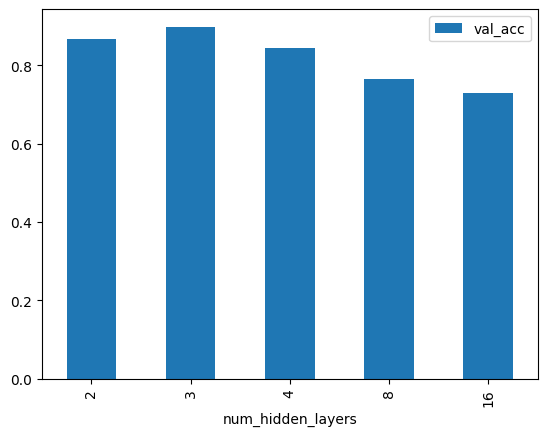

In [14]:
import pandas as pd

pd.DataFrame(val_loss_dicts).plot.bar(x="num_hidden_layers", y="val_acc")

In [15]:
print(pd.DataFrame(val_loss_dicts)[["num_hidden_layers", "val_loss", "val_acc"]].style.hide(axis="index").format(lambda x: f"{x:.2f}", ["val_loss", "val_acc"]).to_latex().replace("_", " "))



\begin{tabular}{rrr}
num hidden layers & val loss & val acc \\
2 & 0.37 & 0.87 \\
3 & 0.28 & 0.90 \\
4 & 0.36 & 0.84 \\
8 & 0.68 & 0.76 \\
16 & 0.59 & 0.73 \\
\end{tabular}



## Load one of the models from the hp search:

In [16]:
# Which `num_hidden_layers` run to load:
num_hidden_layers = 3
results_dict = torch.load(f"room_type_classifier_early_stopping_results_{num_hidden_layers}.pt")

model = results_dict["best_model"]

In [22]:
model.eval()

GATModel(
  (convs): ModuleList(
    (0): GATConv(4, 32, heads=1)
    (1-2): 2 x GATConv(32, 32, heads=1)
  )
  (hidden_linear): Linear(in_features=36, out_features=32, bias=True)
  (linear): Linear(in_features=32, out_features=9, bias=True)
)

In [30]:
ds_test = GraphZoningTypeTestSet('/path/to/modified-swiss-dwellings-v1-test/')

ds_test[0]

Data(edge_index=[2, 80], zoning_type=[38, 4], connectivity=[80, 3], num_nodes=38, file_name='4167.pickle')

In [31]:
ds_test

## Make folder for output graphs

In [ ]:
pred_graph_path = ds_test.graph_path.replace("graph_in", "graph_pred")

os.makedirs(pred_graph_path, exist_ok=True)

pred_graph_path

In [33]:
import pickle

def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

## Make graph_pred graphs

Run inference on the test graph_in files, and save the graph_pred graphs with the added room type attribute.

In [34]:
def inference(model, data_test, device="cpu"):
    model.eval()

    model = model.to(device)

    with torch.no_grad():
        for data in DataLoader(data_test, batch_size=1):
            data = data.to(device)
            pred = torch.argmax(model(data), dim=-1)

            pred = pred.cpu().numpy()

            file_name = data.file_name

            assert len(file_name) == 1

            yield file_name[0], pred

inv_room_mapping = {val: key for key, val in constants.ROOM_MAPPING.items()}

for file_name, pred in inference(model, ds_test, device="cpu"):
    graph_nx = load_pickle(os.path.join(ds_test.graph_path, file_name))

    for node in graph_nx.nodes:
        graph_nx.nodes[node]['room_type'] = pred[node]

    # print(graph_nx.nodes(data=True))

    print(file_name)

    for node in graph_nx.nodes:
        room_name = constants.ROOM_NAMES[graph_nx.nodes[node]['room_type']]

        room_name = inv_room_mapping[room_name]

        pred_zone_name = constants.ZONING_MAPPING[room_name]

        zone_name = constants.ZONING_NAMES[graph_nx.nodes[node]['zoning_type']]

        # Check that the predictions make sense according to the room type -> zoning type mapping
        assert zone_name == pred_zone_name, f"Zone name: {zone_name} Pred zone name: {pred_zone_name}"
    
    save_pickle(graph_nx, os.path.join(pred_graph_path, file_name))

4167.pickle
4168.pickle
4169.pickle
4170.pickle
4171.pickle
4172.pickle
4173.pickle
4174.pickle
4175.pickle
4176.pickle
4177.pickle
4178.pickle
4179.pickle
4180.pickle
4181.pickle
4182.pickle
4183.pickle
4184.pickle
4185.pickle
4186.pickle
4187.pickle
4188.pickle
4189.pickle
4190.pickle
4191.pickle
4192.pickle
4193.pickle
4194.pickle
4195.pickle
4196.pickle
4197.pickle
4198.pickle
4199.pickle
4200.pickle
4201.pickle
4202.pickle
4203.pickle
4204.pickle
4205.pickle
4206.pickle
4207.pickle
4208.pickle
4209.pickle
4210.pickle
4211.pickle
4212.pickle
4213.pickle
4214.pickle
4215.pickle
4216.pickle
4217.pickle
4218.pickle
4219.pickle
4220.pickle
4221.pickle
4222.pickle
4223.pickle
4224.pickle
4225.pickle
4226.pickle
4227.pickle
4228.pickle
4229.pickle
4230.pickle
4231.pickle
4232.pickle
4233.pickle
4234.pickle
4235.pickle
4236.pickle
4237.pickle
4238.pickle
4239.pickle
4240.pickle
4241.pickle
4242.pickle
4243.pickle
4244.pickle
4245.pickle
4246.pickle
4247.pickle
4248.pickle
4249.pickle
4250

In [255]:
model.to("cuda")

GATModel(
  (convs): ModuleList(
    (0): GATConv(4, 32, heads=1)
    (1): GATConv(32, 32, heads=1)
  )
  (linear): Linear(in_features=32, out_features=9, bias=True)
)